In [5]:
%matplotlib inline
from importlib import reload

In [6]:
from lib import util

max_workers = 100
commit_limit = 70
root_dir = "/home/bwhite/Projects/bryanchriswhite"
repo_names = [
#     "storj",
#     "uplink",
    "uplink-c"
]
excluded_exts = set()
ext_whitelist = (
    ".go", ".proto", ".c", ".h", ".sh", ".md", ".xml", ".wixproj", ".wsx", ".cs"
)
filter_ext = util.filter_ext(ext_whitelist, excluded_exts)


In [14]:
from concurrent.futures import Future, as_completed, wait
from typing import List, Tuple, Dict, Iterable
import os.path as path
import time

from lib import git, my_types, repo, worktree
from lib.repo import RepoStat
from lib.my_types import FileAuthors
[reload(m) for m in (git, my_types, repo, worktree)]


start = time.perf_counter()

def res(fs: Iterable):
    return (f.result() for f in fs)

repo_results = {}
for repo in repo_names:
    repo_root = path.join(root_dir, repo)
    rs = RepoStat(repo_root)
    commit_authors = rs.blame('master',
                              file_filter=filter_ext,
                              limit=commit_limit)
    results = []
    for commit_date, file_authors in [f.result() for f in commit_authors]:
        new_results = {file:f.result() for (file, f) in file_authors.items() if f is not None}
        results.append((commit_date, new_results))
    repo_results[repo] = results

end = time.perf_counter()
print(str.format("done: {}s!", round(end - start, 2)))
print(str.format("excluded file extensions: {}", excluded_exts))

done: 12.31s!
excluded file extensions: {'', '.sum', '.mod'}


In [15]:
from lib import report, util
[reload(m) for m in (report, util)]

# TODO: refactor
totals_dict = util.sum_repo_commit_lines(repo_results)


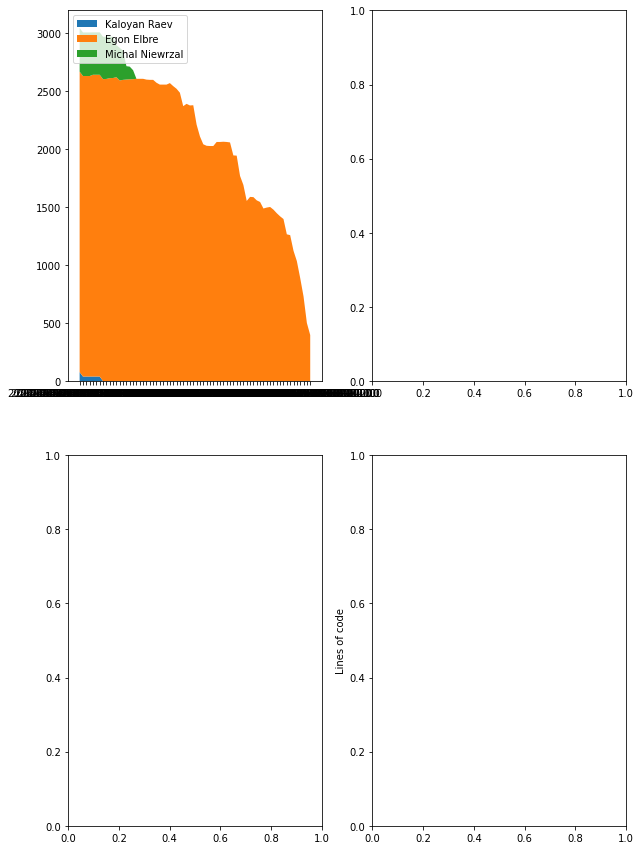

In [17]:
from lib import graph
reload(graph)

graph.repo_stackplots(totals_dict)

In [ ]:
# from github import Github
#
# apikey = open("github.apikey")
#
# g = Github()
# org = g.get_organization("storj")
# repos = org.get_repos()
# page = repos.get_page(0)
#
# storj_repos = page